# Example Workflow for CM2.6

- Interpolate atmosphere onto ocean
- Recalculate flux terms from ocean res (`full_res_*`)
- Coarsen the recalculated flux + flux input fields
- Recompute flux terms once again from coarsened input fields (`coarse_res_*`)
- Look at the difference (`full_res_* - coarse_res_*`)

In [2]:
# !mamba install aerobulk-python -y

## Problems with distributed

Using the threaded scheduler is currently the only way I can finish writing out zarr files. This is however quite slow (a lot more cores would help tremendously in speeding this up). 
I am trying to debug this in `cm26_pipeline-debug-distributed.ipynb`. For now I will use this as a brute force 'leave running all night' way to get anything to analyze.

In [4]:
from multiprocessing.pool import ThreadPool
import dask
# dask.config.set(pool=ThreadPool(32))# blows out the memory?
# dask.config.set(pool=ThreadPool(24))# coare3p6 needs more memory?
# dask.config.set(pool=ThreadPool(12))# this worked for ecmwf and ncar
dask.config.set(pool=ThreadPool(8))

In [5]:
from aerobulk import skin, noskin
import fsspec
import xarray as xr
import numpy as np
import xesmf as xe
import os
from intake import open_catalog
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import gcsfs
from dask.diagnostics import ProgressBar

# 👇 replace with your key 
with open('/home/jovyan/keys/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)
subfolder_full = 'ocean-transport-group/scale-aware-air-sea/outputs/temp/'
subfolder_final = 'ocean-transport-group/scale-aware-air-sea/outputs/'

algo = 'coare3p6'
# algo='ncar'
# algo='ecmwf'
# algo='andreas'

In [6]:
def write_split_zarr(store, ds, split_dim='time', chunks=1, split_interval=180):
    """Write a large dataset in a sequence of batches split along one of the dataset dimensions.
    This can be helpful to e.g. avoid problems with overly eager dask schedulers
    """
    # Got my inspiration for this mostly here: https://github.com/pydata/xarray/issues/6069
    
    # determine the variables and coordinates that depend on the split_dim
    other_dims = [di for di in ds.dims if di != split_dim]
    split_vars_coords = [va for va in ds.variables if split_dim in ds[va].dims and va not in ds.dims]
    non_split_vars_coords = [va for va in ds.variables if va not in split_vars_coords and va not in ds.dims]
    
    # Generate a stripped dataset that only contains variables/coordinates that do not depend on `split_dim`
    ds_stripped = ds.drop_vars(split_vars_coords+[split_dim])
        
    # initialize the store without writing values
    print('initializing store')
    ds.to_zarr(
        store,
        compute=False,
        encoding={split_dim:{"chunks":[chunks]}},
        consolidated=True, # TODO: Not sure if this is proper. Might have to consolidate the whole thing as a last step?
    )
    
    # Write out only the non-split variables/coordinates
    if len(non_split_vars_coords) > 0:
        print('Writing coordinates')
        ds_stripped.to_zarr(store, mode='a') #TODO: Not 100% sure what this mode is (what is the difference to `a`)?
        # with `w` there are issues with the shape. I guess a is 'add'. This is honestly not clear enough in the xarray docs.
    
    # TODO: what about the attrs?
    
    # Populate split chunks as regions
    n = len(ds[split_dim])
    splits = list(range(0,n,split_interval))

    # Make sure the last item in the list covers the full length of the time on our dataset
    if splits[-1] != n:
        splits = splits + [n]
    
    for ii in tqdm(range(len(splits)-1)):
        print(f'Writing split {ii}')
        # TODO: put some retry logic in here...
        start = splits[ii]
        stop = splits[ii+1]
        
        ds_write = ds.isel({split_dim:slice(start, stop)})
        print(f'Start: {ds_write[split_dim][0].data}')
        print(f'Stop: {ds_write[split_dim][-1].data}')
        
        # strip everything except the values
        drop_vars = non_split_vars_coords+other_dims
        ds_write = ds_write.drop_vars(drop_vars)
        
        with ProgressBar():
            ds_write.to_zarr(store, region={split_dim:slice(start, stop)}, mode='a')#why are the variables not instantiated in the init step

In [7]:
def noskin_ds_wrapper(ds_in, algo='ecmwf', **kwargs):
    ds_out = xr.Dataset()
    ds_in = ds_in.copy(deep=False)
    
    sst = ds_in.surface_temp + 273.15
    t_zt = ds_in.t_ref
    hum_zt = ds_in.q_ref
    u_zu = ds_in.u_ref
    v_zu = ds_in.v_ref
    slp = ds_in.slp * 100 # check this
    zu = 10
    zt = 2
    
    ql, qh, taux, tauy, evap =  noskin(
        sst,
        t_zt,
        hum_zt,
        u_zu,
        v_zu,
        slp=slp,
        algo=algo,
        zt=2,
        zu=10,
        **kwargs
    )
    ds_out['ql'] = ql
    ds_out['qh'] = qh
    ds_out['evap'] = evap
    ds_out['taux'] = taux 
    ds_out['tauy'] = tauy
    return ds_out

In [8]:
kwargs = dict(consolidated=True, use_cftime=True)
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds_ocean  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
ds_flux  = cat["GFDL_CM2_6_control_ocean_boundary_flux"].to_dask()
# xarray says not to do this
# ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs)
ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', **kwargs)
ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()
# cut to same time
all_dims = set(list(ds_ocean.dims)+list(ds_atmos.dims))
ds_ocean, ds_atmos = xr.align(
    ds_ocean,
    ds_atmos,
    join='inner',
    exclude=(di for di in all_dims if di !='time')
)
# instead do this
ds_atmos = ds_atmos.chunk({'time':1})

## Regridding the atmos variables onto the ocean grid

In [9]:
fs = gcsfs.GCSFileSystem(token=token)
path = 'ocean-transport-group/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr'
mapper = fs.get_mapper(path)
ds_regridder = xr.open_zarr(mapper).load()
regridder = xe.Regridder(
    ds_atmos.olr.to_dataset(name='dummy').isel(time=0),
    ds_ocean.surface_temp.to_dataset(name='dummy').isel(time=0),
    'bilinear',
    weights=ds_regridder,
    periodic=True
)
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x576_2700x3600_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 576) 
Output grid shape:          (2700, 3600) 
Periodic in longitude?      True

In [10]:
ds_atmos_regridded = regridder(ds_atmos[['slp', 'v_ref', 'u_ref', 't_ref', 'q_ref', 'wind']])# We are only doing noskin for now , 'swdn_sfc', 'lwdn_sfc'
ds_atmos_regridded

## combine into merged dataset
ds_merged = xr.merge(
    [
        ds_atmos_regridded,
        ds_ocean[['surface_temp']],
    ]
)
ds_merged = ds_merged.transpose(
    'xt_ocean', 'yt_ocean', 'time'
)
ds_merged

<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Data variables:
    slp           (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    v_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    u_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    t_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    q_ref         (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    wind          (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    surface_temp  (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## for coare3p6 (filter windspeed) 🚨 that is not enough

In [11]:
# ds_merged = ds_merged.where(ds_merged.wind < 50)

## Recalculate Fluxes on the native ocean grid (most resource intense step)
For now I am writing out the aerobulk-python results to a cloud bucket, reloading them and then continue to the next step. 

TODO: Eventually it would be nice if we could skip this step alltoghether and stream the full computation (this + coarsening), so we do not write this huge amount of data to the bucket.

In [12]:
# ds_out = noskin_ds_wrapper(ds_merged, algo=algo, input_range_check=False)
ds_out = noskin_ds_wrapper(ds_merged, algo=algo, input_range_check=True)
ds_out

/srv/conda/envs/notebook/lib/python3.9/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


<xarray.Dataset>
Dimensions:   (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Data variables:
    ql        (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    qh        (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    evap      (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    taux      (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>
    tauy      (xt_ocean, yt_ocean, time) float32 dask.array<chunksize=(3600, 2700, 1), meta=np.ndarray>

In [ ]:
# Ad-hoc hack (splitting the dataset into batches and append to zarr store
path = f'{subfolder_full}CM26_high_res_output_{algo}.zarr'
mapper = fs.get_mapper(path)
print(f"Writing to {path}")

# # delete the mapper (only uncomment if you want to start from scratch!)
# fs.rm(path, recursive=True)

write_split_zarr(mapper, ds_out, split_interval=144)

Writing to ocean-transport-group/scale-aware-air-sea/outputs/temp/CM26_high_res_output_coare3p6.zarr
initializing store


# so apparently you can get messages from within the fortran code? 

I got this for coare3p0:
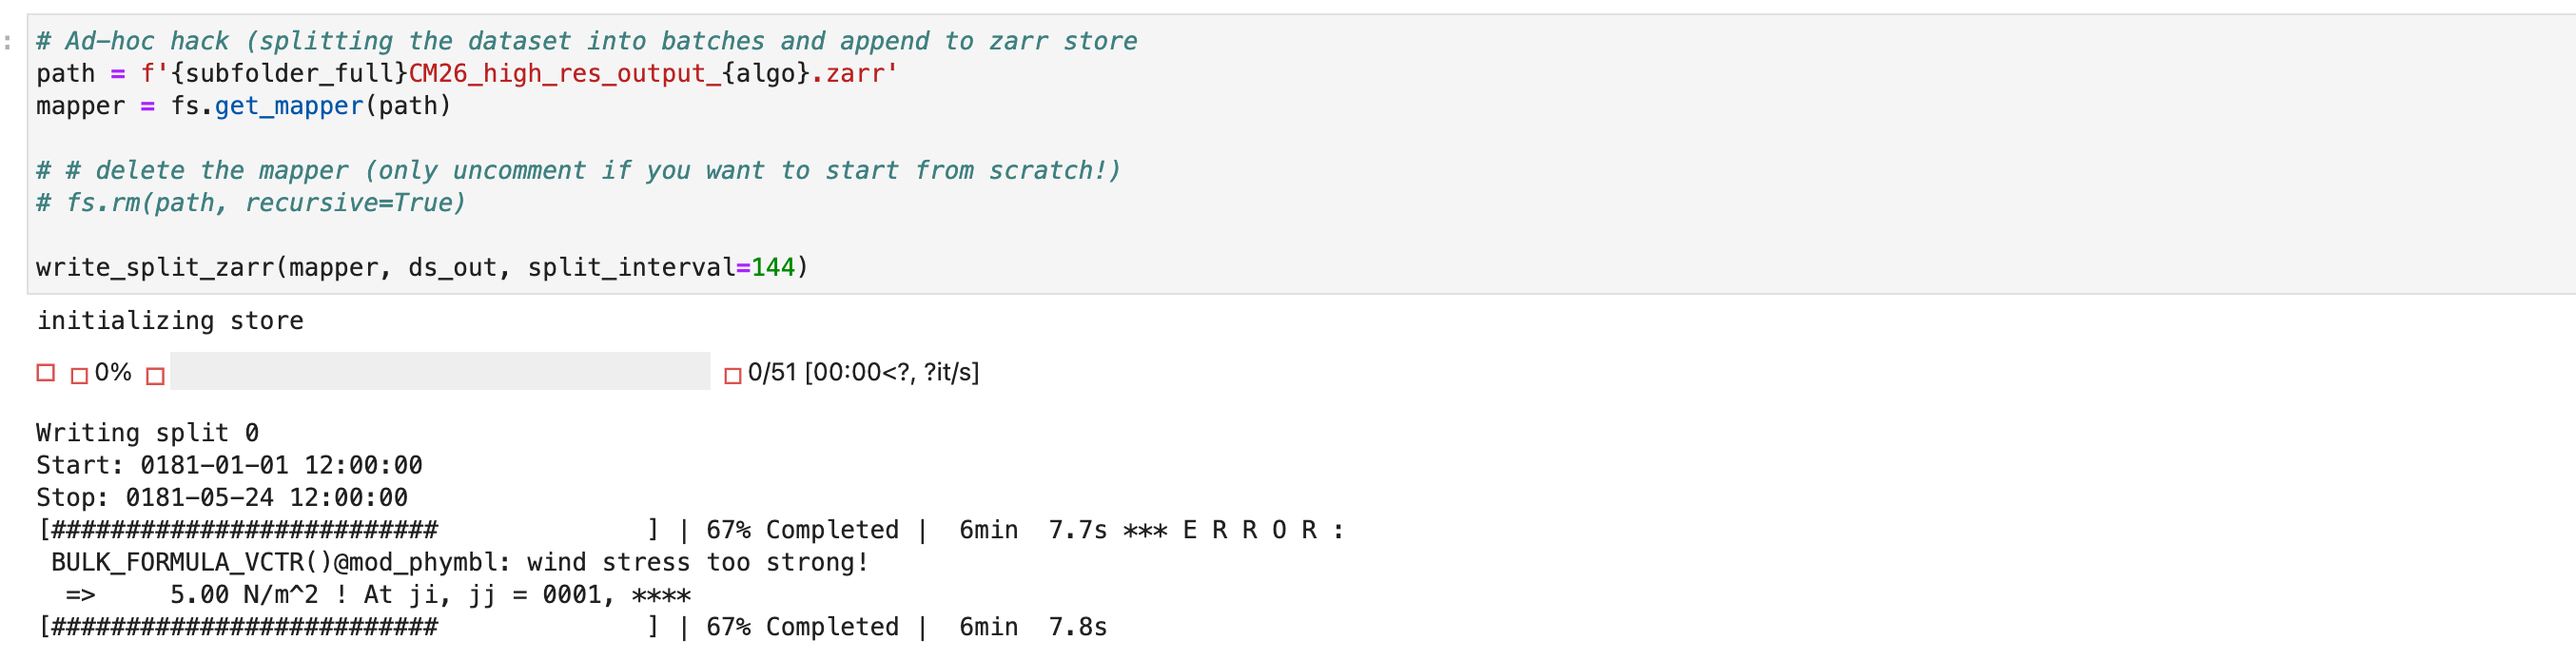

Super strange

**Note**: It seems that error was just a glitch...I have now set up the split writing in a way that should avoid having duplicate times. 

If the error happens again, I need to see how I can build in some sort of retry logic.

### Notes:

I could actually write out the sst, u,v etc here too. That way the next processing step might be quicker? Then again, this here is wayy slower, and we might not want to slow it down even further.

## Coarsening the input/output and recomputing the 'large scale' output

In [ ]:
# reload the flux output
path = f'{subfolder_full}CM26_high_res_output_{algo}.zarr'
mapper = fs.get_mapper(path)
ds_recomputed_full = xr.open_dataset(mapper, engine='zarr', consolidated=False, use_cftime=True, chunks={'time':1})
ds_recomputed_full

In [ ]:
# combine all variables (input + flux output + area) in one dataset. 
ds = xr.merge([ds_merged, ds_recomputed_full], join='inner')
ds = ds.assign_coords(area=ds_oc_grid.area_t)#.load()
ds

### Manually do a weighted coarsen
> Would be nice if this could work with the xr.weighted logic!

In [ ]:
coarsen_win = dict(xt_ocean=20, yt_ocean=20)
mean_dims = ['xt_ocean', 'yt_ocean']

masked_area = ds.area.where(~np.isnan(ds.surface_temp.isel(time=0)))
ds_weighted = ds * masked_area
coarsened_area = masked_area.coarsen(**coarsen_win).sum(mean_dims).drop_vars(['time'])#.squeeze(drop=True)# This does not work. Annoying!
ds_coarsened = ds_weighted.coarsen(**coarsen_win).sum(mean_dims) / coarsened_area
# add area t
ds_coarsened = ds_coarsened.assign_coords(area=coarsened_area)


# Apply a new (strict) landmask to fields that had nans in them before
coarsened_landmask = coarsened_landmask = np.isnan(ds['surface_temp'].isel(time=0)).coarsen(**coarsen_win).sum(mean_dims)>0
for var in ['qh', 'ql', 'surface_temp', 't_ref', 'slp']:
    ds_coarsened[var] = ds_coarsened[var].where(~coarsened_landmask)
ds_coarsened

In [ ]:
ds_recompute_coarse = noskin_ds_wrapper(ds_coarsened, input_range_check=False)
# add all the recomputed variables from coarsened ouput back to the input dataset
for var in ds_recompute_coarse.data_vars:
    ds_coarsened[var+'_large_scale'] = ds_recompute_coarse[var]

In [ ]:
# write this out as final store (this is the store that we can use for analysis)
path = f'{subfolder_final}CM26_final_output_full_time_{algo}.zarr'
mapper = fs.get_mapper(path)
ds_coarsened.attrs['algo'] = algo

with ProgressBar():
    ds_coarsened.to_zarr(mapper, mode='w', consolidated=True)

## Some plots to check the output

In [ ]:
# reload the final store (needs the first cell to be executed, but should otherwise work independently)
path = f'{subfolder_final}CM26_final_output_full_time_{algo}.zarr'
mapper = fs.get_mapper(path)
ds_plot = xr.open_dataset(mapper, engine='zarr', consolidated=True, use_cftime=True, chunks='auto')
ds_plot

In [ ]:
for var in ['ql', 'qh', 'evap', 'taux', 'tauy']:
    with ProgressBar():
        full = ds_plot[var].mean('time').load()
        large_scale = ds_plot[var+'_large_scale'].mean('time').load()
        small_scale = full-large_scale

        # not quite sure if we should look at the mean of the difference or the difference of the mean over time...
        plot_kwargs = {'y':'yt_ocean', 'robust':True, 'center':0}
        plt.figure(figsize=[25,4])
        plt.subplot(1,4,1)
        full.plot(**plot_kwargs)
        plt.title('Full output coarsened')
        plt.subplot(1,4,2)
        large_scale.plot(**plot_kwargs)
        plt.title('Output from coarsened input')
        plt.subplot(1,4,3)
        small_scale.plot(**plot_kwargs)
        plt.title('Small Scale Absolute')
        plt.subplot(1,4,4)
        (small_scale/full*100).plot(vmax=10, **plot_kwargs)
        plt.title('Small Scale Relative')
        plt.show()